# **Reframing**

### ***Loading Libraries***

In [23]:
# Operating Systems
import os
import shutil

# Numerical Computing
import numpy as np

# Data Manipuation
import pandas as pd

# SciPy
import scipy
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# BigQuery
from google.cloud import bigquery
from google.colab import auth

# Scikit-Learn
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow_hub import KerasLayer
from tensorflow import feature_column as fc
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D

In [2]:
# User Authentication
auth.authenticate_user()

# BigQuery Library
# !pip install --upgrade google-cloud-bigquery

In [3]:
project_id = 'core-catalyst-425922-v9'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

# BigQuery Client Config
client = bigquery.Client(project=project_id)

In [4]:
bq = bigquery.Client()

In [5]:
query = """
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  plurality,
  mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND is_male = true
  AND gestation_weeks = 38
  AND mother_age = 28
  AND mother_race = 1
  AND plurality = 1
  AND RAND() < 0.01
"""

In [6]:
df = bq.query(query).to_dataframe()
df.head()

,weight_pounds,is_male,gestation_weeks,mother_age,plurality,mother_race
0,8.900062,True,38,28,1,1
1,6.188376,True,38,28,1,1
2,6.437498,True,38,28,1,1
3,8.437091,True,38,28,1,1
4,5.749656,True,38,28,1,1


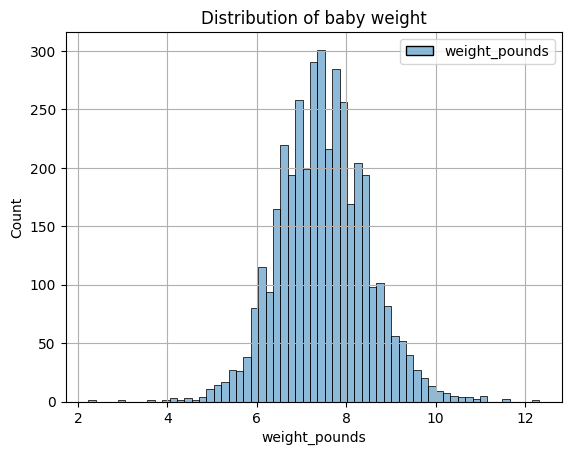

In [9]:
fig = sns.histplot(df[["weight_pounds"]])
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_pounds")
fig.figure.savefig("weight_distrib.png")

plt.grid(True)
plt.show()

In [10]:
np.mean(df.weight_pounds)

7.489264656153268

In [11]:
np.std(df.weight_pounds)

0.9921072222278825

In [12]:
weeks = 36

age = 28

query = """
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  plurality,
  mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND is_male = true
  AND gestation_weeks = {}
  AND mother_age = {}
  AND mother_race = 1
  AND plurality = 1
  AND RAND() < 0.01
""".format(weeks, age)

df = bq.query(query).to_dataframe()
print('weeks={} age={} mean={} stddev={}'.format(weeks, age, np.mean(df.weight_pounds), np.std(df.weight_pounds)))

weeks=36 age=28 mean=6.773063712006491 stddev=1.1553051432482795


### ***Comparing Categorical Label & Regression***

In [14]:
df = pd.read_csv("/content/babyweight_train.csv")

In [15]:
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

def categorical_weight(weight_pounds):
    if weight_pounds < 3.31:
        return 0
    elif weight_pounds >= 3.31 and weight_pounds < 5.5:
        return 1
    elif weight_pounds >= 5.5 and weight_pounds < 8.8:
        return 2
    else:
        return 3

df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x))

In [16]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race,weight_category
0,7.749249,False,12,Single(1),40,1.0,2
1,7.561856,True,12,Single(1),40,2.0,2
2,7.187070,False,12,Single(1),34,3.0,2
3,6.375769,True,12,Single(1),36,2.0,2
4,7.936641,False,12,Single(1),35,0.0,2


In [19]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']

LABEL_CLS = ['weight_category']
LABEL_REG = ['weight_pounds']

N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]

y_train_cls = encode_labels(df[LABEL_CLS][:N_TRAIN])
y_train_reg = df[LABEL_REG][:N_TRAIN]

y_valid_cls = encode_labels(df[LABEL_CLS][N_TRAIN:])
y_valid_reg = df[LABEL_REG][N_TRAIN:]

In [20]:
# Train/Validation Dataset for Classification Model
cls_train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train_cls))
cls_valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid_cls))

# Train/Validation Dataset for Regression Model
reg_train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train_reg.values))
reg_valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid_reg.values))

In [21]:
for data_type in [cls_train_data, reg_train_data]:
    for dict_slice in data_type.take(1):
        print("{}\n".format(dict_slice))

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>)

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([7.74924851])>)



In [24]:
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [25]:
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}

inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# Create Hidden Layers
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)

# Create Classification Model
cls_output = layers.Dense(4, activation="softmax")(h2)
cls_model = tf.keras.models.Model(inputs=inputs, outputs=cls_output)

cls_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


# Create Regression Model
reg_output = layers.Dense(1, activation="relu")(h2)
reg_model = tf.keras.models.Model(inputs=inputs, outputs=reg_output)

reg_model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

In [26]:
cls_model.fit(cls_train_data.batch(50), epochs=1)

val_loss, val_accuracy = cls_model.evaluate(cls_valid_data.batch(X_valid.shape[0]))
print("Validation accuracy for classifcation model: {}".format(val_accuracy))

1/1 [==============================] - 0s 424ms/step - loss: 0.8950 - accuracy: 0.7168
Validation accuracy for classifcation model: 0.7168370485305786


In [27]:
reg_model.fit(reg_train_data.batch(50), epochs=1)

val_loss, val_mse = reg_model.evaluate(reg_valid_data.batch(X_valid.shape[0]))
print("Validation RMSE for regression model: {}".format(val_mse**0.5))

1/1 [==============================] - 0s 400ms/step - loss: 1.7994 - mse: 1.7994
Validation RMSE for regression model: 1.3414256819315666


In [28]:
preds = reg_model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                             "is_male": tf.convert_to_tensor(["True"]),
                             "mother_age": tf.convert_to_tensor([28]),
                             "mother_race": tf.convert_to_tensor(["1.0"]),
                             "plurality": tf.convert_to_tensor(["Single(1)"])},
                          steps=1).squeeze()
preds

1/1 [==============================] - 0s 169ms/step


array(7.4669275, dtype=float32)

In [29]:
preds = cls_model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                             "is_male": tf.convert_to_tensor(["True"]),
                             "mother_age": tf.convert_to_tensor([28]),
                             "mother_race": tf.convert_to_tensor(["1.0"]),
                             "plurality": tf.convert_to_tensor(["Single(1)"])},
                          steps=1).squeeze()
preds

1/1 [==============================] - 0s 141ms/step


array([1.9709271e-08, 1.4036930e-04, 8.5783309e-01, 1.4202653e-01],
      dtype=float32)

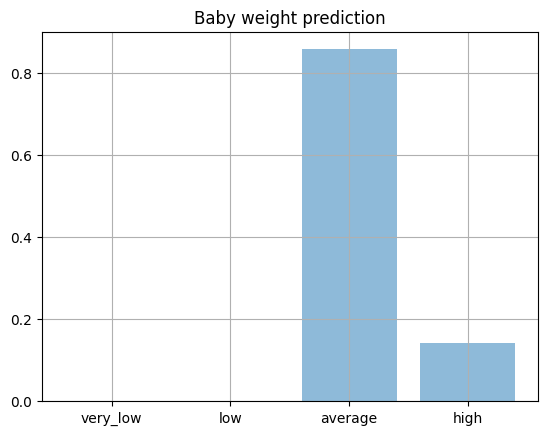

In [33]:
objects = ('very_low', 'low', 'average', 'high')
y_pos = np.arange(len(objects))
predictions = list(preds)

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Baby weight prediction')

plt.grid(True)
plt.show()

### ***Increasing Categorical Label's Number***

In [34]:
df = pd.read_csv("/content/babyweight_train.csv")

df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

# Setting Categorical Label
MIN = np.min(df.weight_pounds)

MAX = np.max(df.weight_pounds)

NBUCKETS = 50

def categorical_weight(weight_pounds, weight_min, weight_max, nbuckets=10):
    buckets = np.linspace(weight_min, weight_max, nbuckets)

    return np.digitize(weight_pounds, buckets) - 1

df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x, MIN, MAX, NBUCKETS))

In [35]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL_COLUMN = ['weight_category']

N_TRAIN = int(df.shape[0] * 0.80)

X_train, y_train = df[FEATURES][:N_TRAIN], encode_labels(df[LABEL_COLUMN][:N_TRAIN])
X_valid, y_valid = df[FEATURES][N_TRAIN:], encode_labels(df[LABEL_COLUMN][N_TRAIN:])

In [36]:
train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid))

In [37]:
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

In [38]:
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# Building Model's DenseFeatures
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# Model
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)
output = layers.Dense(NBUCKETS, activation="softmax")(h2)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [39]:
model.fit(train_data.batch(50), epochs=1)

4234/4234 [==============================] - 23s 5ms/step - loss: 2.6131 - accuracy: 0.1329


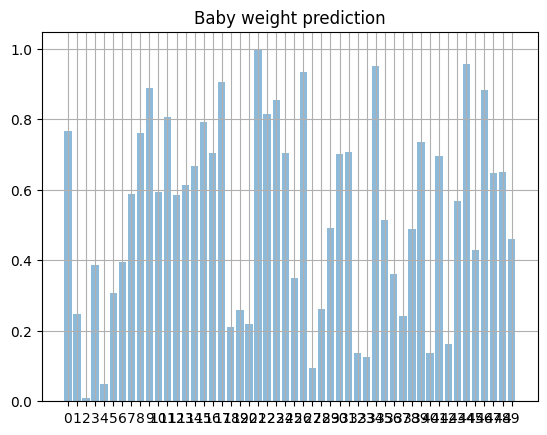

In [42]:
NBUCKETS = 50  # Example value
preds = np.random.rand(NBUCKETS)  # Example value to generate random predictions

objects = [str(_) for _ in range(NBUCKETS)]
y_pos = np.arange(len(objects))
predictions = list(preds)

if len(y_pos) != len(predictions):
    raise ValueError(f"Length mismatch: y_pos has length {len(y_pos)}, but predictions has length {len(predictions)}")

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Baby weight prediction')

plt.grid(True)
plt.show()

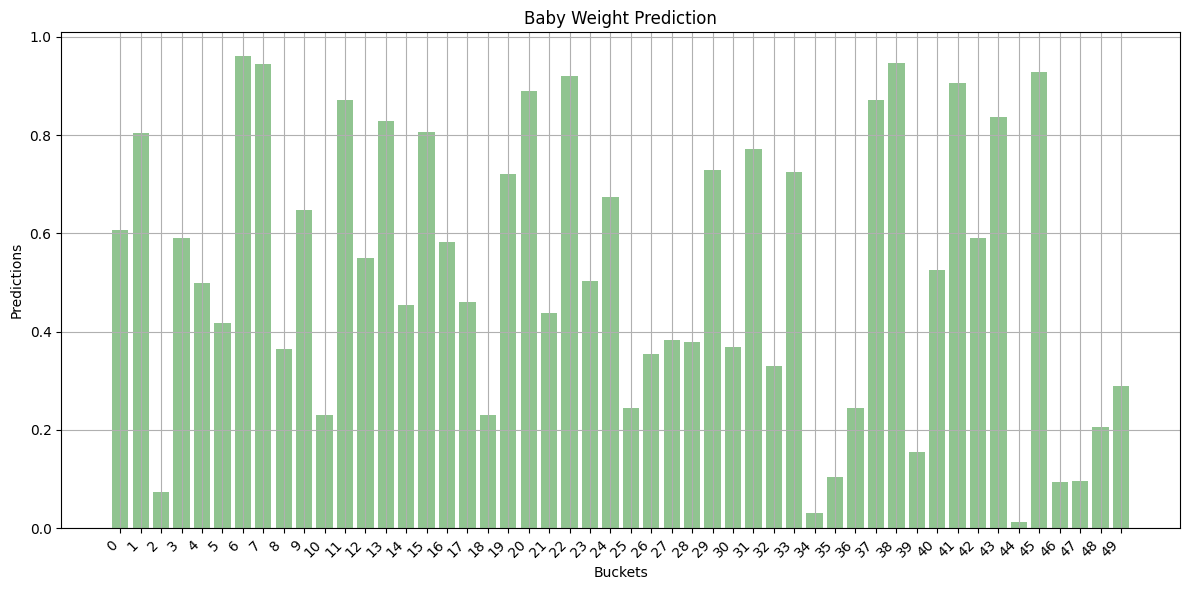

In [46]:

NBUCKETS = 50
preds = np.random.rand(NBUCKETS)

objects = [str(_) for _ in range(NBUCKETS)]
y_pos = np.arange(len(objects))
predictions = list(preds)

if len(y_pos) != len(predictions):
    raise ValueError(f"Length mismatch: y_pos has length {len(y_pos)}, but predictions has length {len(predictions)}")

plt.figure(figsize=(12, 6))
plt.bar(y_pos, predictions, align='center', alpha=0.5, color='forestgreen')
plt.xticks(y_pos, objects, rotation=45, ha='right', fontsize=10)
plt.title('Baby Weight Prediction')
plt.xlabel('Buckets')
plt.ylabel('Predictions')

plt.tight_layout()
plt.grid(True)
plt.show()

### ***Restricting The Prediction Range***

In [47]:
MIN_Y =  3

MAX_Y = 20

input_size = 10

inputs = keras.layers.Input(shape=(input_size,))
h1 = keras.layers.Dense(20, 'relu')(inputs)
h2 = keras.layers.Dense(1, 'sigmoid')(h1)  # 0-1 range
output = keras.layers.Lambda(lambda y : (y*(MAX_Y-MIN_Y) + MIN_Y))(h2) # scaled
model = keras.Model(inputs, output)

# Model Fitting
model.compile(optimizer='adam', loss='mse')
batch_size = 2048
for i in range(0, 10):
    x = np.random.rand(batch_size, input_size)
    y = 0.5*(x[:,0] + x[:,1]) * (MAX_Y-MIN_Y) + MIN_Y
    model.fit(x, y)

# Verifying
min_y = np.finfo(np.float64).max
max_y = np.finfo(np.float64).min
for i in range(0, 10):
    x = np.random.randn(batch_size, input_size)
    y = model.predict(x)
    min_y = min(y.min(), min_y)
    max_y = max(y.max(), max_y)
print('min={} max={}'.format(min_y, max_y))

64/64 [==============================] - 0s 1ms/step
min=3.007011651992798 max=19.977737426757812
